In [46]:
import graphlab as gl
import pandas as pd
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim import corpora, models, similarities

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

product_elec_rating_stats_samsung_sorted_shortlist=gl.load_sframe('./product_elec_rating_stats_samsung_sorted_shortlist')

In [47]:
elec_rev_data= gl.load_sframe('./elec_rev_data_new/')
elec_rev_data=elec_rev_data.unpack('X1',column_name_prefix='')

In [48]:
#compute the cumulative months column
product_elec_rating_stats_samsung_sorted_shortlist['cumulativemonths']=12*product_elec_rating_stats_samsung_sorted_shortlist['reviewyear']+product_elec_rating_stats_samsung_sorted_shortlist['reviewmonth']

In [49]:
product_elec_rating_stats_samsung_sorted_shortlist.head()

asin,reviewmonth,reviewyear,Count,Avg of overall,Stdv of overall,Total review count,Total review months
B004CGHDEO,12,2010,1,5.0,0.0,1152,42
B004CGHDEO,1,2011,1,4.0,0.0,1152,42
B004CGHDEO,2,2011,1,3.0,0.0,1152,42
B004CGHDEO,3,2011,1,5.0,0.0,1152,42
B004CGHDEO,6,2011,1,1.0,0.0,1152,42
B004CGHDEO,7,2011,1,5.0,0.0,1152,42
B004CGHDEO,8,2011,3,4.66666666667,0.471404520791,1152,42
B004CGHDEO,9,2011,8,4.875,0.330718913883,1152,42
B004CGHDEO,10,2011,7,4.57142857143,0.728431359085,1152,42
B004CGHDEO,11,2011,6,4.83333333333,0.37267799625,1152,42


In [50]:
#filtering the products with Tital review count less than 500 

product_elec_rating_stats_samsung_sorted_shortlist=product_elec_rating_stats_samsung_sorted_shortlist[product_elec_rating_stats_samsung_sorted_shortlist['Total review count']>500]

product_elec_rating_stats_samsung_sorted_shortlist.print_rows(1000)



+------------+-------------+------------+-------+----------------+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall |
+------------+-------------+------------+-------+----------------+
| B004CGHDEO |      12     |    2010    |   1   |      5.0       |
| B004CGHDEO |      1      |    2011    |   1   |      4.0       |
| B004CGHDEO |      2      |    2011    |   1   |      3.0       |
| B004CGHDEO |      3      |    2011    |   1   |      5.0       |
| B004CGHDEO |      6      |    2011    |   1   |      1.0       |
| B004CGHDEO |      7      |    2011    |   1   |      5.0       |
| B004CGHDEO |      8      |    2011    |   3   | 4.66666666667  |
| B004CGHDEO |      9      |    2011    |   8   |     4.875      |
| B004CGHDEO |      10     |    2011    |   7   | 4.57142857143  |
| B004CGHDEO |      11     |    2011    |   6   | 4.83333333333  |
| B004CGHDEO |      12     |    2011    |   11  | 4.18181818182  |
| B004CGHDEO |      1      |    2012    |   7   | 3.5714285714

In [51]:
##getting a unique list of samsung prodcuts of interest
samsung_product_short_list=list(set(list(product_elec_rating_stats_samsung_sorted_shortlist['asin'])))

In [52]:
cnt=0
extremenegslope=-0.25
extremeposslope=0.25
def my_neg_condition(x):
    return x <extremenegslope
def my_pos_condition(x):
    return x >extremeposslope
neg_count_item=[]
pos_count_item=[]
for itemid,item in enumerate(samsung_product_short_list):
    itemframe = product_elec_rating_stats_samsung_sorted_shortlist[product_elec_rating_stats_samsung_sorted_shortlist['asin'] == item]
    rating_list=list(itemframe['Avg of overall'])
    cumulative_month_list=list(itemframe['cumulativemonths'])
    item_slopes=[]
    for i in range(0, len(cumulative_month_list)-1): 
        item_slopes.append((rating_list[i+1]-rating_list[i])/float(cumulative_month_list[i+1]-cumulative_month_list[i]))
       
    neg_count_item.append(sum(map(my_neg_condition, item_slopes))/float(len(item_slopes)))
    pos_count_item.append(sum(map(my_pos_condition, item_slopes))/float(len(item_slopes)))

neg_count_item=[i*100 for i in neg_count_item]
pos_count_item=[i*100 for i in pos_count_item]
print neg_count_item
print 
print pos_count_item


[8.333333333333332, 26.08695652173913, 9.090909090909092, 12.5, 24.137931034482758, 0.0, 37.5, 27.27272727272727, 41.46341463414634, 22.58064516129032, 29.166666666666668, 12.5, 7.142857142857142, 15.384615384615385, 31.25, 8.333333333333332, 16.666666666666664, 0.0, 14.285714285714285, 28.947368421052634]

[16.666666666666664, 17.391304347826086, 22.727272727272727, 21.875, 20.689655172413794, 5.0, 22.916666666666664, 27.27272727272727, 36.58536585365854, 25.806451612903224, 20.833333333333336, 18.75, 17.857142857142858, 15.384615384615385, 18.75, 8.333333333333332, 8.333333333333332, 8.333333333333332, 9.523809523809524, 28.947368421052634]


In [53]:
#finding top 5 products with more percentage negative slopes

items_of_int_n=sorted(range(len(neg_count_item)), key=lambda i: neg_count_item[i], reverse=True)[:5]

print neg_count_item[items_of_int_n[0]]
print neg_count_item[items_of_int_n[1]]
print neg_count_item[items_of_int_n[2]]
print neg_count_item[items_of_int_n[3]]
print neg_count_item[items_of_int_n[4]]

41.4634146341
37.5
31.25
29.1666666667
28.9473684211


In [54]:
#finding top 5 products with more percentage positive slopes
items_of_int_p=sorted(range(len(pos_count_item)), key=lambda i: pos_count_item[i], reverse=True)[:5]

print pos_count_item[items_of_int_p[0]]
print pos_count_item[items_of_int_p[1]]
print pos_count_item[items_of_int_p[2]]
print pos_count_item[items_of_int_p[3]]
print pos_count_item[items_of_int_p[4]]

36.5853658537
28.9473684211
27.2727272727
25.8064516129
22.9166666667


In [55]:
print 'top negative items'
for i in items_of_int_n:
    print samsung_product_short_list[i]
print 
print 'top positive items'
for i in items_of_int_p:
    print samsung_product_short_list[i]



top negative items
B004CGHDEO
B0079KZZKO
B00BFDHVAS
B0080CXSOU
B004DBD4TG

top positive items
B004CGHDEO
B004DBD4TG
B008AJLPYS
B005VFG06W
B0079KZZKO


In [56]:
##reading meta data to identify product names
elec_meta_data=gl.load_sframe('./elec_meta_data_new/')
elec_meta_data = elec_meta_data.unpack('X1', column_name_prefix='')

In [57]:
print 'top negative item names'
n_item_title_list=[]
p_item_title_list=[]
for i in items_of_int_n:   
    item_title_n= elec_meta_data[elec_meta_data['asin']==samsung_product_short_list[i] ]['title']
    print samsung_product_short_list[i]
    print item_title_n
    n_item_title_list.append(item_title_n)
print 
print 'top positive item names'
for i in items_of_int_p:
    item_title_p= elec_meta_data[elec_meta_data['asin']==samsung_product_short_list[i] ]['title']
    print samsung_product_short_list[i]
    print item_title_p
    p_item_title_list.append(item_title_p)

top negative item names
B004CGHDEO
['Samsung ETA-P10JBEGSTA Galaxy Tab Detachable Multi Travel Charger with USB to 30 Pin Data Cable - Black', ... ]
B0079KZZKO
['Samsung WIS12ABGNX Wireless LAN Adapter', ... ]
B00BFDHVAS
['Samsung BD-F5900 3D Wi-Fi Blu-ray Disc Player (2013 Model)', ... ]
B0080CXSOU
['Adapter HDMI EPL 3FHU for Samsung Galaxy s3', ... ]
B004DBD4TG
['Samsung Galaxy Tab Data Cable (Charging) USB to 30 Pin (ECC1DP0UBEGSTA)', ... ]

top positive item names
B004CGHDEO
['Samsung ETA-P10JBEGSTA Galaxy Tab Detachable Multi Travel Charger with USB to 30 Pin Data Cable - Black', ... ]
B004DBD4TG
['Samsung Galaxy Tab Data Cable (Charging) USB to 30 Pin (ECC1DP0UBEGSTA)', ... ]
B008AJLPYS
['Samsung Ultra Portable Slim DVD+/-RW USB External Drive, Black SE-218BB/RSBS', ... ]
B005VFG06W
['Komputerbay 64GB Class 10 UHS-1 Grade 1 70MB/s MicroSDXC Pro Memory Card using Samsung NAND with Komputerbay SD Adapter', ... ]
B0079KZZKO
['Samsung WIS12ABGNX Wireless LAN Adapter', ... ]


In [58]:
#run it only once to convert sframes to lists
temp=[item[0] for item in n_item_title_list]
n_item_title_list=temp

temp=[item[0] for item in p_item_title_list]
p_item_title_list=temp

print n_item_title_list
print p_item_title_list

['Samsung ETA-P10JBEGSTA Galaxy Tab Detachable Multi Travel Charger with USB to 30 Pin Data Cable - Black', 'Samsung WIS12ABGNX Wireless LAN Adapter', 'Samsung BD-F5900 3D Wi-Fi Blu-ray Disc Player (2013 Model)', 'Adapter HDMI EPL 3FHU for Samsung Galaxy s3', 'Samsung Galaxy Tab Data Cable (Charging) USB to 30 Pin (ECC1DP0UBEGSTA)']
['Samsung ETA-P10JBEGSTA Galaxy Tab Detachable Multi Travel Charger with USB to 30 Pin Data Cable - Black', 'Samsung Galaxy Tab Data Cable (Charging) USB to 30 Pin (ECC1DP0UBEGSTA)', 'Samsung Ultra Portable Slim DVD+/-RW USB External Drive, Black SE-218BB/RSBS', 'Komputerbay 64GB Class 10 UHS-1 Grade 1 70MB/s MicroSDXC Pro Memory Card using Samsung NAND with Komputerbay SD Adapter', 'Samsung WIS12ABGNX Wireless LAN Adapter']


In [59]:
print len(n_item_title_list)
print n_item_title_list
len(items_of_int_n)
print items_of_int_n

5
['Samsung ETA-P10JBEGSTA Galaxy Tab Detachable Multi Travel Charger with USB to 30 Pin Data Cable - Black', 'Samsung WIS12ABGNX Wireless LAN Adapter', 'Samsung BD-F5900 3D Wi-Fi Blu-ray Disc Player (2013 Model)', 'Adapter HDMI EPL 3FHU for Samsung Galaxy s3', 'Samsung Galaxy Tab Data Cable (Charging) USB to 30 Pin (ECC1DP0UBEGSTA)']
[8, 6, 14, 10, 19]


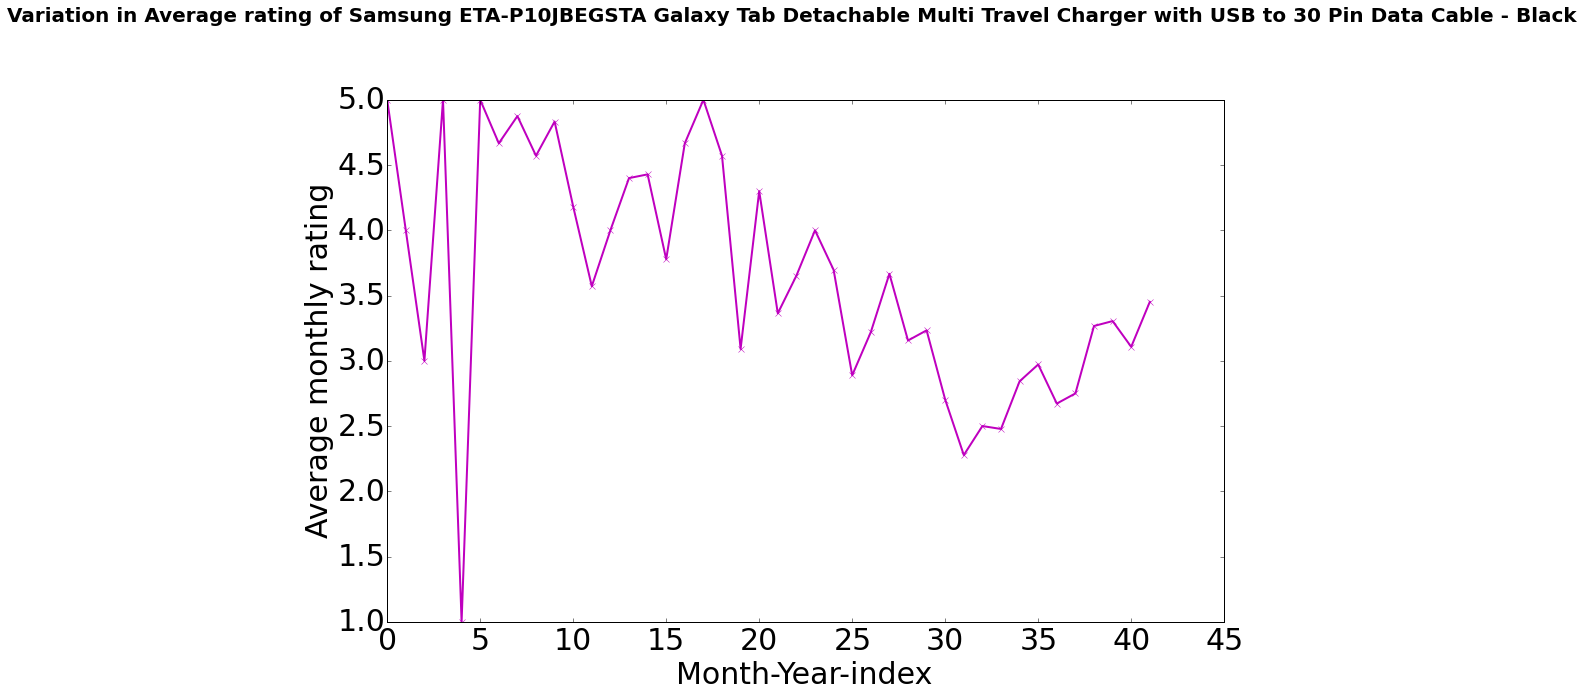

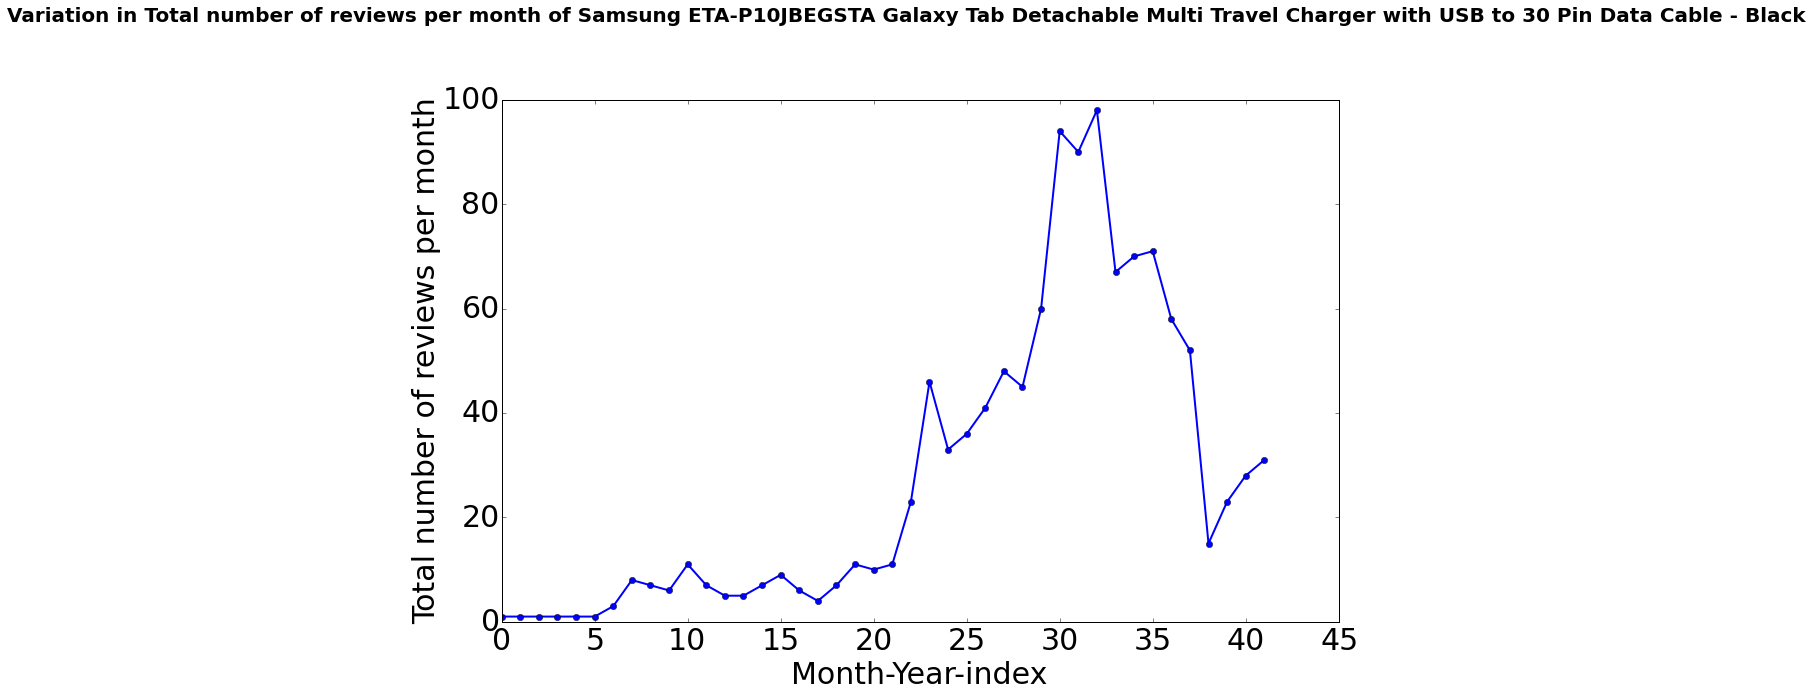

+------------+-------------+------------+-------+----------------+-----+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall | ... |
+------------+-------------+------------+-------+----------------+-----+
| B004CGHDEO |      12     |    2010    |   1   |      5.0       | ... |
| B004CGHDEO |      1      |    2011    |   1   |      4.0       | ... |
| B004CGHDEO |      2      |    2011    |   1   |      3.0       | ... |
| B004CGHDEO |      3      |    2011    |   1   |      5.0       | ... |
| B004CGHDEO |      6      |    2011    |   1   |      1.0       | ... |
| B004CGHDEO |      7      |    2011    |   1   |      5.0       | ... |
| B004CGHDEO |      8      |    2011    |   3   | 4.66666666667  | ... |
| B004CGHDEO |      9      |    2011    |   8   |     4.875      | ... |
| B004CGHDEO |      10     |    2011    |   7   | 4.57142857143  | ... |
| B004CGHDEO |      11     |    2011    |   6   | 4.83333333333  | ... |
| B004CGHDEO |      12     |    2011    |   11  | 4

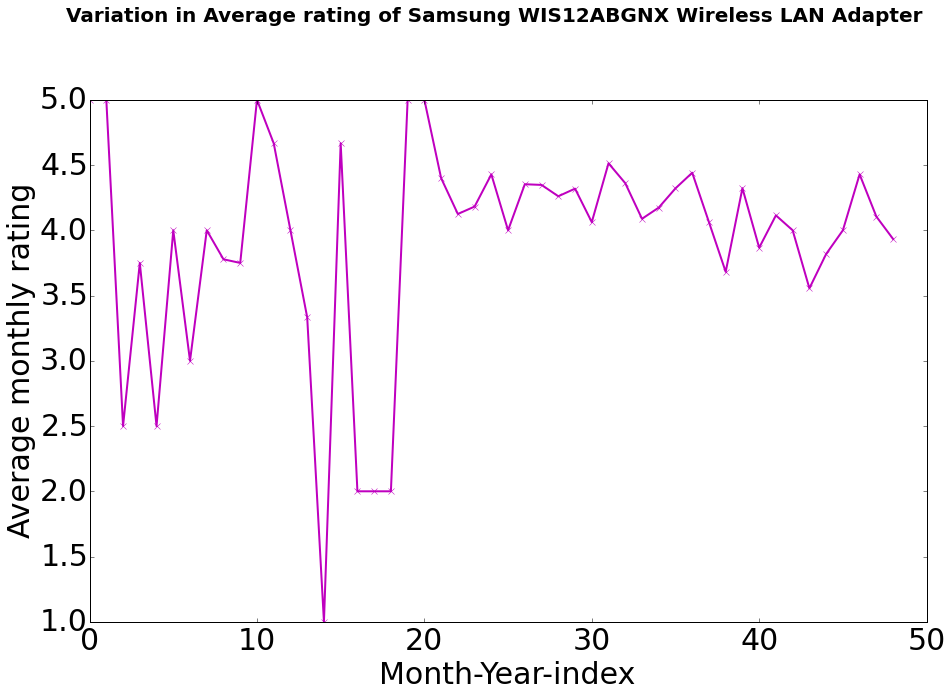

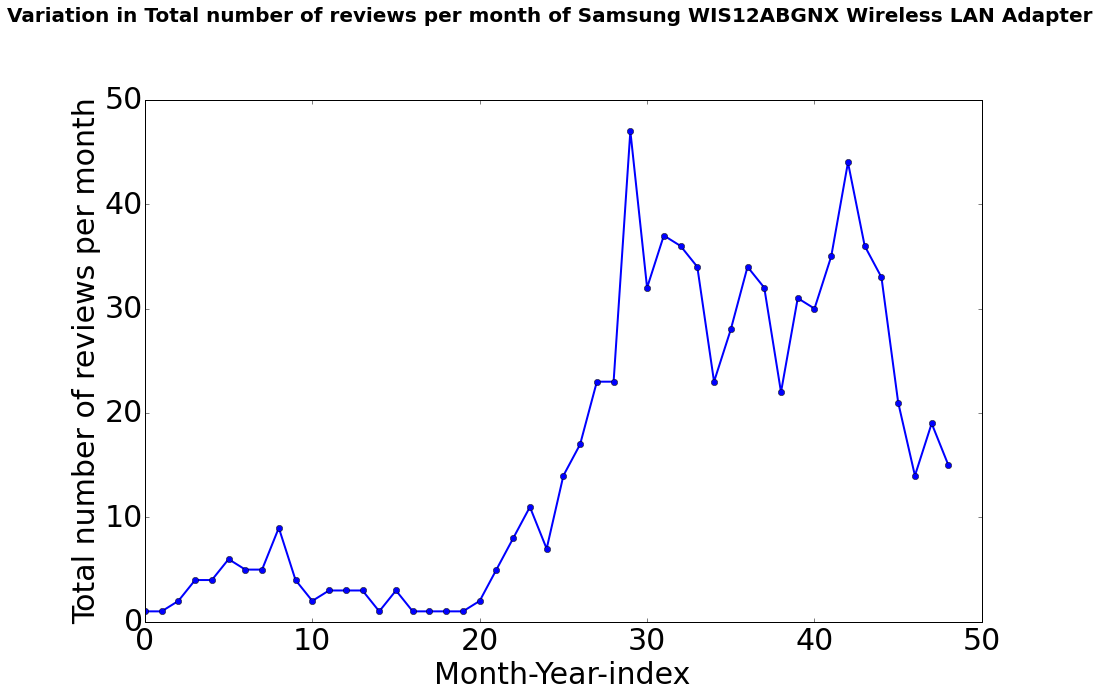

+------------+-------------+------------+-------+----------------+-----+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall | ... |
+------------+-------------+------------+-------+----------------+-----+
| B0079KZZKO |      4      |    2010    |   1   |      5.0       | ... |
| B0079KZZKO |      5      |    2010    |   1   |      5.0       | ... |
| B0079KZZKO |      6      |    2010    |   2   |      2.5       | ... |
| B0079KZZKO |      7      |    2010    |   4   |      3.75      | ... |
| B0079KZZKO |      8      |    2010    |   4   |      2.5       | ... |
| B0079KZZKO |      9      |    2010    |   6   |      4.0       | ... |
| B0079KZZKO |      10     |    2010    |   5   |      3.0       | ... |
| B0079KZZKO |      11     |    2010    |   5   |      4.0       | ... |
| B0079KZZKO |      12     |    2010    |   9   | 3.77777777778  | ... |
| B0079KZZKO |      1      |    2011    |   4   |      3.75      | ... |
| B0079KZZKO |      3      |    2011    |   2   |  

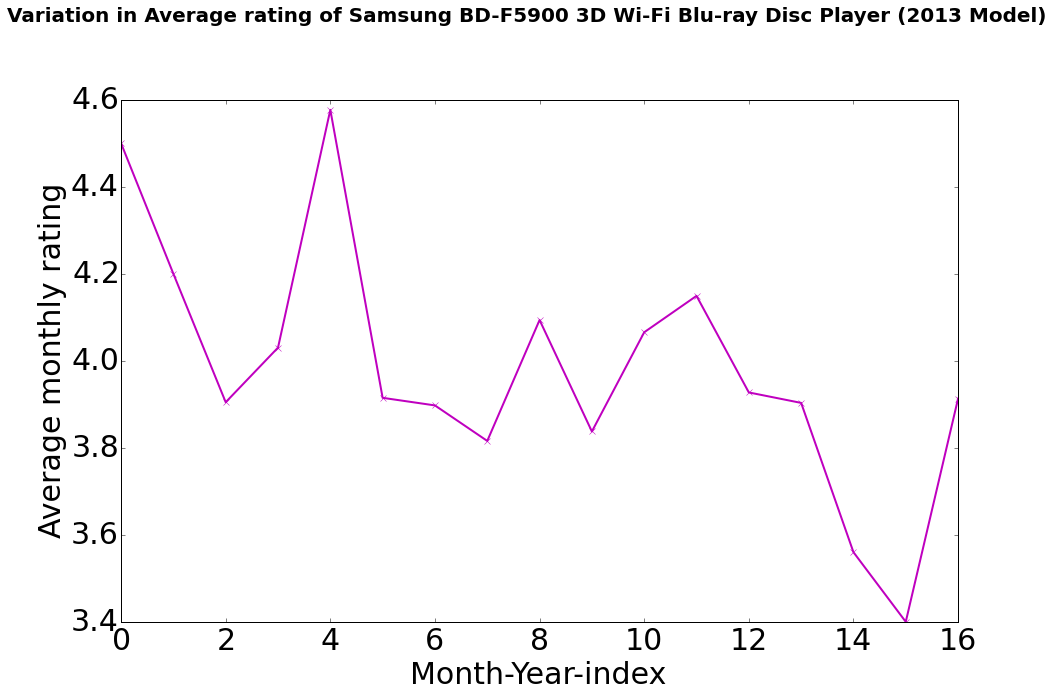

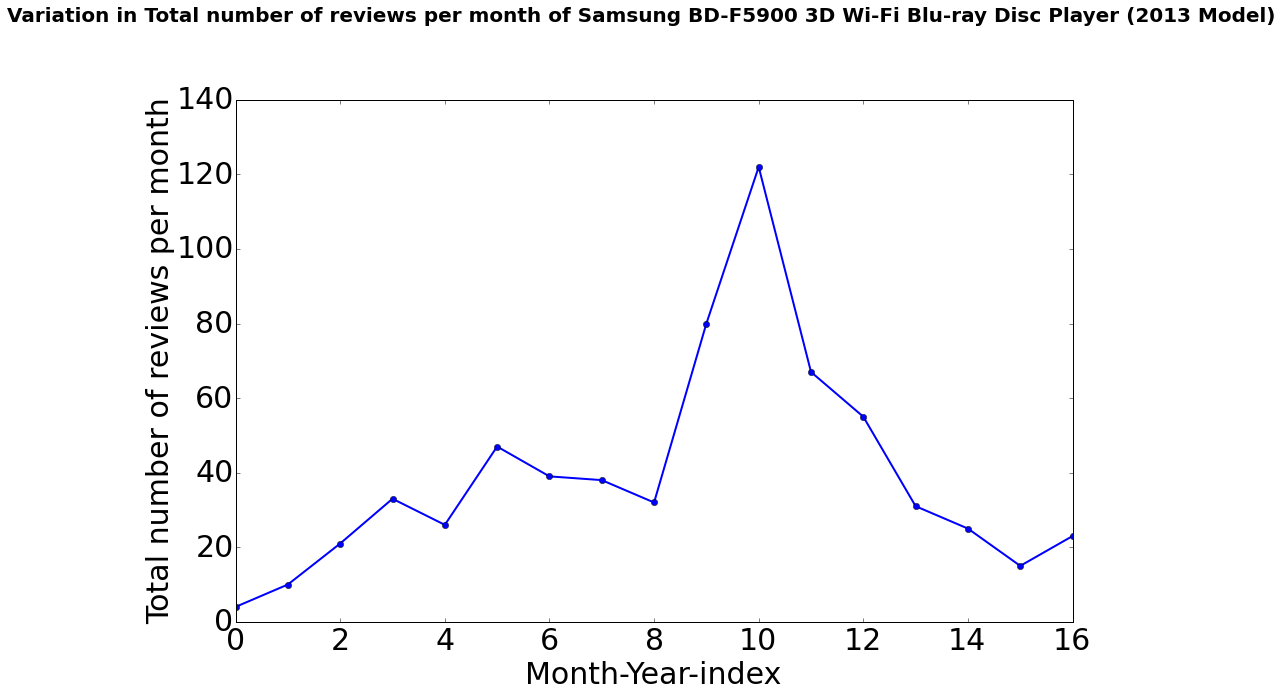

+------------+-------------+------------+-------+----------------+-----+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall | ... |
+------------+-------------+------------+-------+----------------+-----+
| B00BFDHVAS |      3      |    2013    |   4   |      4.5       | ... |
| B00BFDHVAS |      4      |    2013    |   10  |      4.2       | ... |
| B00BFDHVAS |      5      |    2013    |   21  | 3.90476190476  | ... |
| B00BFDHVAS |      6      |    2013    |   33  |  4.0303030303  | ... |
| B00BFDHVAS |      7      |    2013    |   26  | 4.57692307692  | ... |
| B00BFDHVAS |      8      |    2013    |   47  | 3.91489361702  | ... |
| B00BFDHVAS |      9      |    2013    |   39  | 3.89743589744  | ... |
| B00BFDHVAS |      10     |    2013    |   38  | 3.81578947368  | ... |
| B00BFDHVAS |      11     |    2013    |   32  |    4.09375     | ... |
| B00BFDHVAS |      12     |    2013    |   80  |     3.8375     | ... |
| B00BFDHVAS |      1      |    2014    |  122  | 4

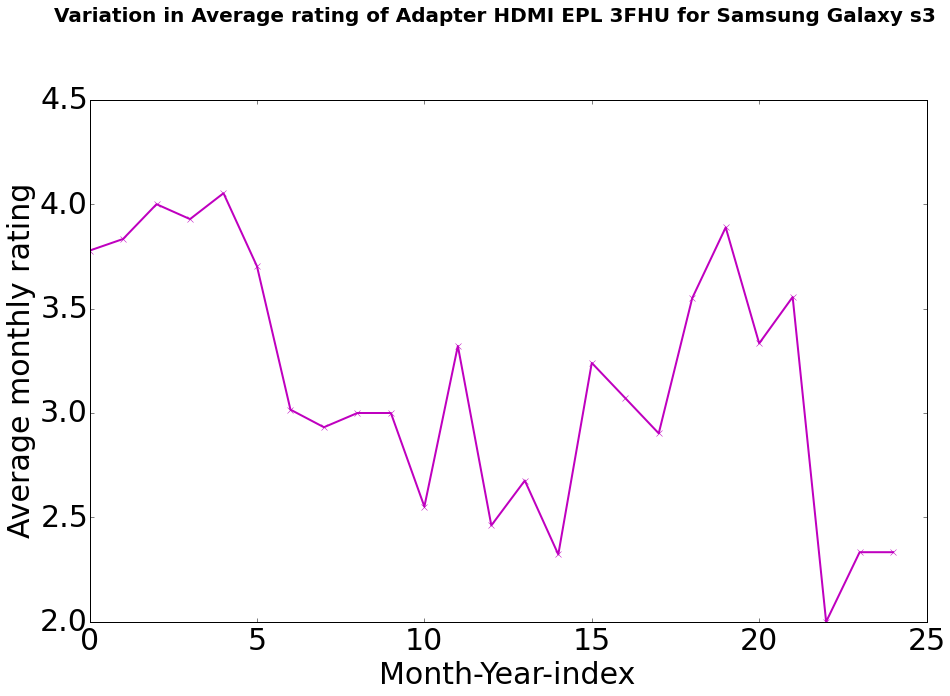

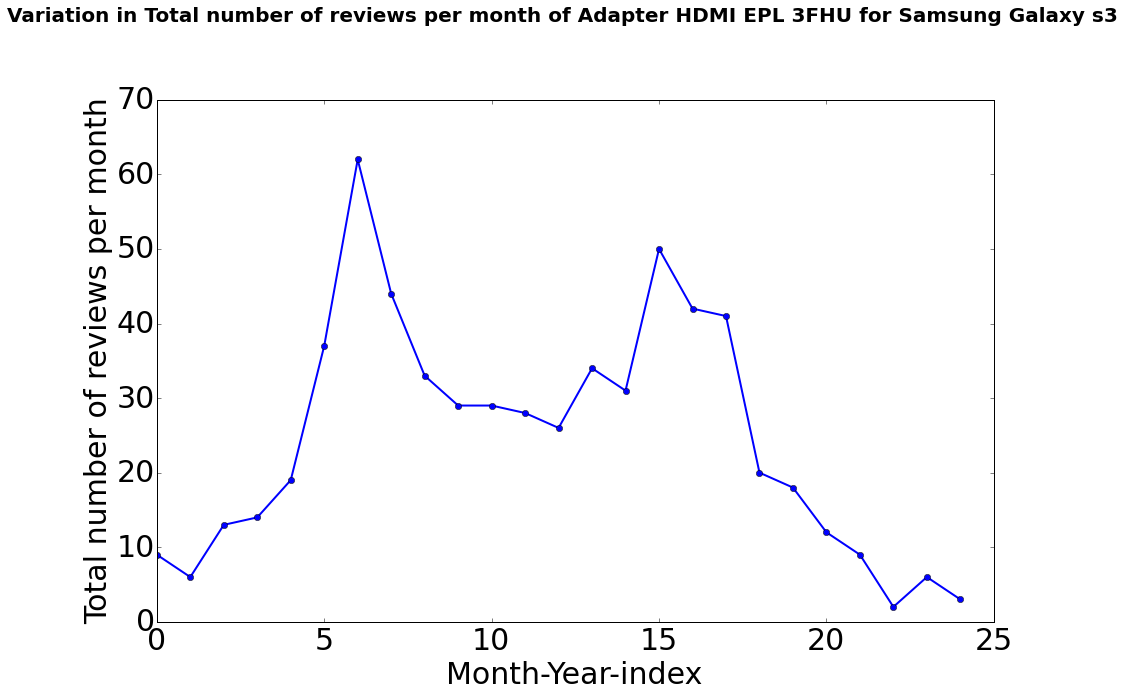

+------------+-------------+------------+-------+----------------+-----+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall | ... |
+------------+-------------+------------+-------+----------------+-----+
| B0080CXSOU |      7      |    2012    |   9   | 3.77777777778  | ... |
| B0080CXSOU |      8      |    2012    |   6   | 3.83333333333  | ... |
| B0080CXSOU |      9      |    2012    |   13  |      4.0       | ... |
| B0080CXSOU |      10     |    2012    |   14  | 3.92857142857  | ... |
| B0080CXSOU |      11     |    2012    |   19  | 4.05263157895  | ... |
| B0080CXSOU |      12     |    2012    |   37  |  3.7027027027  | ... |
| B0080CXSOU |      1      |    2013    |   62  | 3.01612903226  | ... |
| B0080CXSOU |      2      |    2013    |   44  | 2.93181818182  | ... |
| B0080CXSOU |      3      |    2013    |   33  |      3.0       | ... |
| B0080CXSOU |      4      |    2013    |   29  |      3.0       | ... |
| B0080CXSOU |      5      |    2013    |   29  | 2

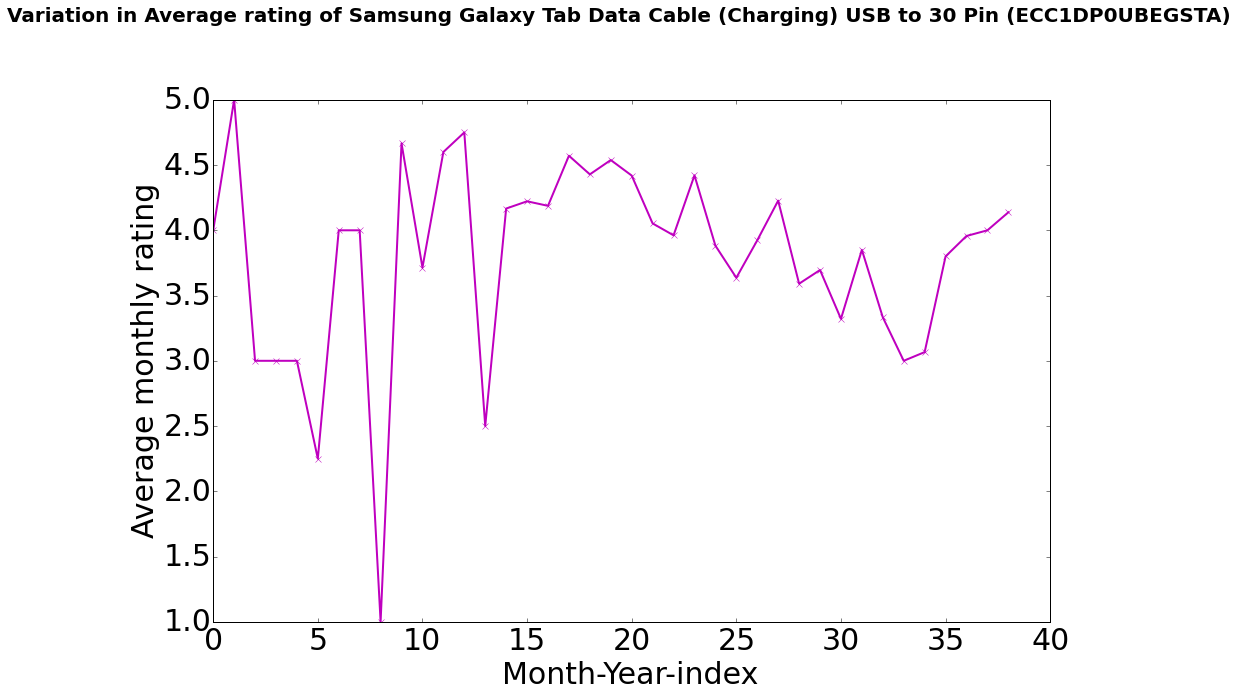

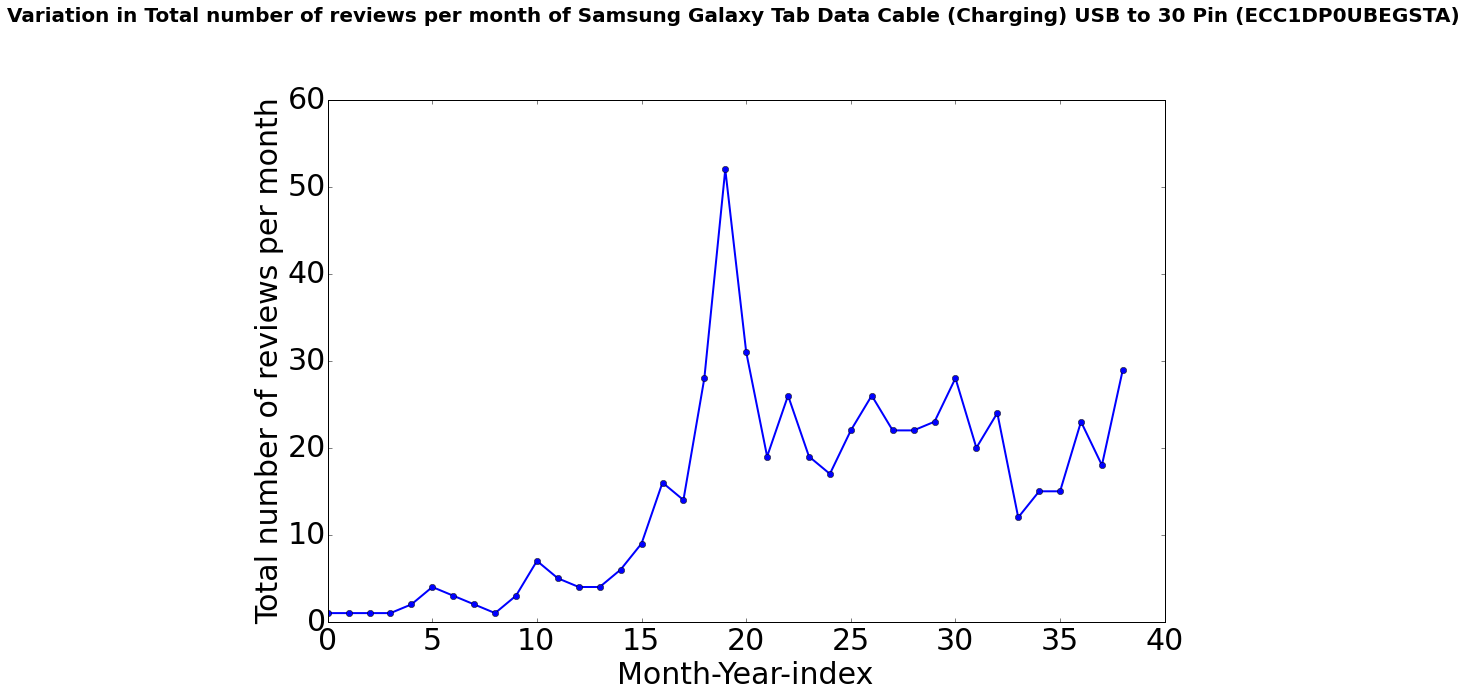

+------------+-------------+------------+-------+----------------+-----+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall | ... |
+------------+-------------+------------+-------+----------------+-----+
| B004DBD4TG |      12     |    2010    |   1   |      4.0       | ... |
| B004DBD4TG |      1      |    2011    |   1   |      5.0       | ... |
| B004DBD4TG |      3      |    2011    |   1   |      3.0       | ... |
| B004DBD4TG |      5      |    2011    |   1   |      3.0       | ... |
| B004DBD4TG |      6      |    2011    |   2   |      3.0       | ... |
| B004DBD4TG |      7      |    2011    |   4   |      2.25      | ... |
| B004DBD4TG |      8      |    2011    |   3   |      4.0       | ... |
| B004DBD4TG |      10     |    2011    |   2   |      4.0       | ... |
| B004DBD4TG |      11     |    2011    |   1   |      1.0       | ... |
| B004DBD4TG |      1      |    2012    |   3   | 4.66666666667  | ... |
| B004DBD4TG |      3      |    2012    |   7   | 3

In [60]:
#plots for negative products
ctr=-1
for i in items_of_int_n:
    ctr=ctr+1
    producthist= product_elec_rating_stats_samsung_sorted_shortlist[product_elec_rating_stats_samsung_sorted_shortlist['asin'] 
                                                        == samsung_product_short_list[i]]
        
    timeline=range(len(producthist['Avg of overall']))
    
    fig = plt.figure(figsize=(15,10))

    figtitle='Variation in Average rating of'+' '+n_item_title_list[ctr]
  
    fig.suptitle(figtitle, fontsize=20, fontweight='bold')

    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=0.85)
#     ax.set_title('axes title',fontsize=30)

    ax.set_xlabel('Month-Year-index',fontsize=30)
    ax.set_ylabel('Average monthly rating',fontsize=30)
    for tick in ax.xaxis.get_major_ticks(): 
        tick.label.set_fontsize(30) 
    for tick in ax.yaxis.get_major_ticks(): 
        tick.label.set_fontsize(30)   


    ax.plot(timeline,list(producthist['Avg of overall']),'-mx',linewidth=2)

#     ax.axis([0, 50, 0, 5.5])
    plt.show()
    
    figtitle='Variation in Total number of reviews per month of'+' '+n_item_title_list[ctr]
   
    fig = plt.figure(figsize=(15,10))
    fig.suptitle(figtitle, fontsize=20, fontweight='bold')

    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=0.85)
#     ax.set_title('axes title',fontsize=30)

    ax.set_xlabel('Month-Year-index',fontsize=30)
    ax.set_ylabel('Total number of reviews per month',fontsize=30)
    for tick in ax.xaxis.get_major_ticks(): 
        tick.label.set_fontsize(30) 
    for tick in ax.yaxis.get_major_ticks(): 
        tick.label.set_fontsize(30)   


    ax.plot(timeline,list(producthist['Count']),'-bo',linewidth=2)
    
    plt.show()
    
    producthist.print_rows(num_rows=5000, num_columns=5)
    
    del producthist

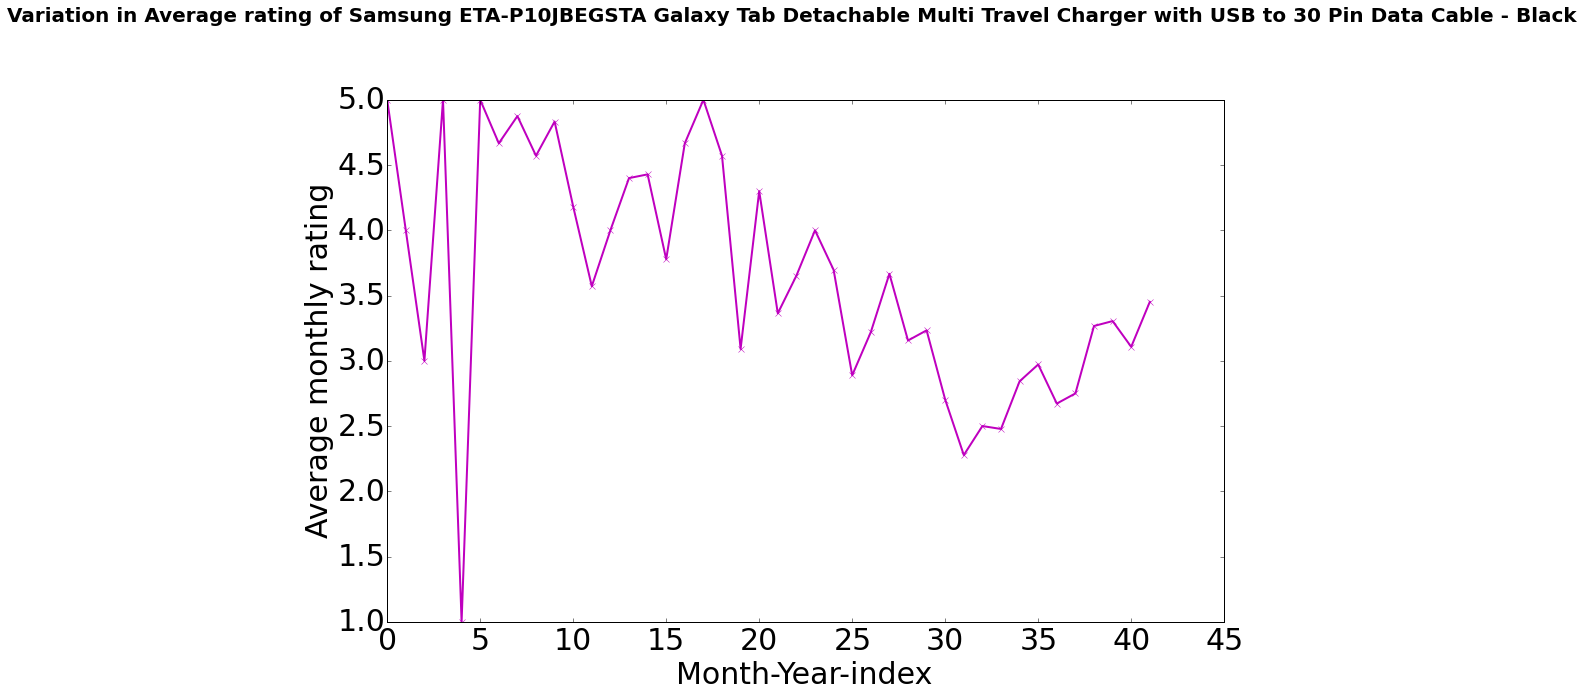

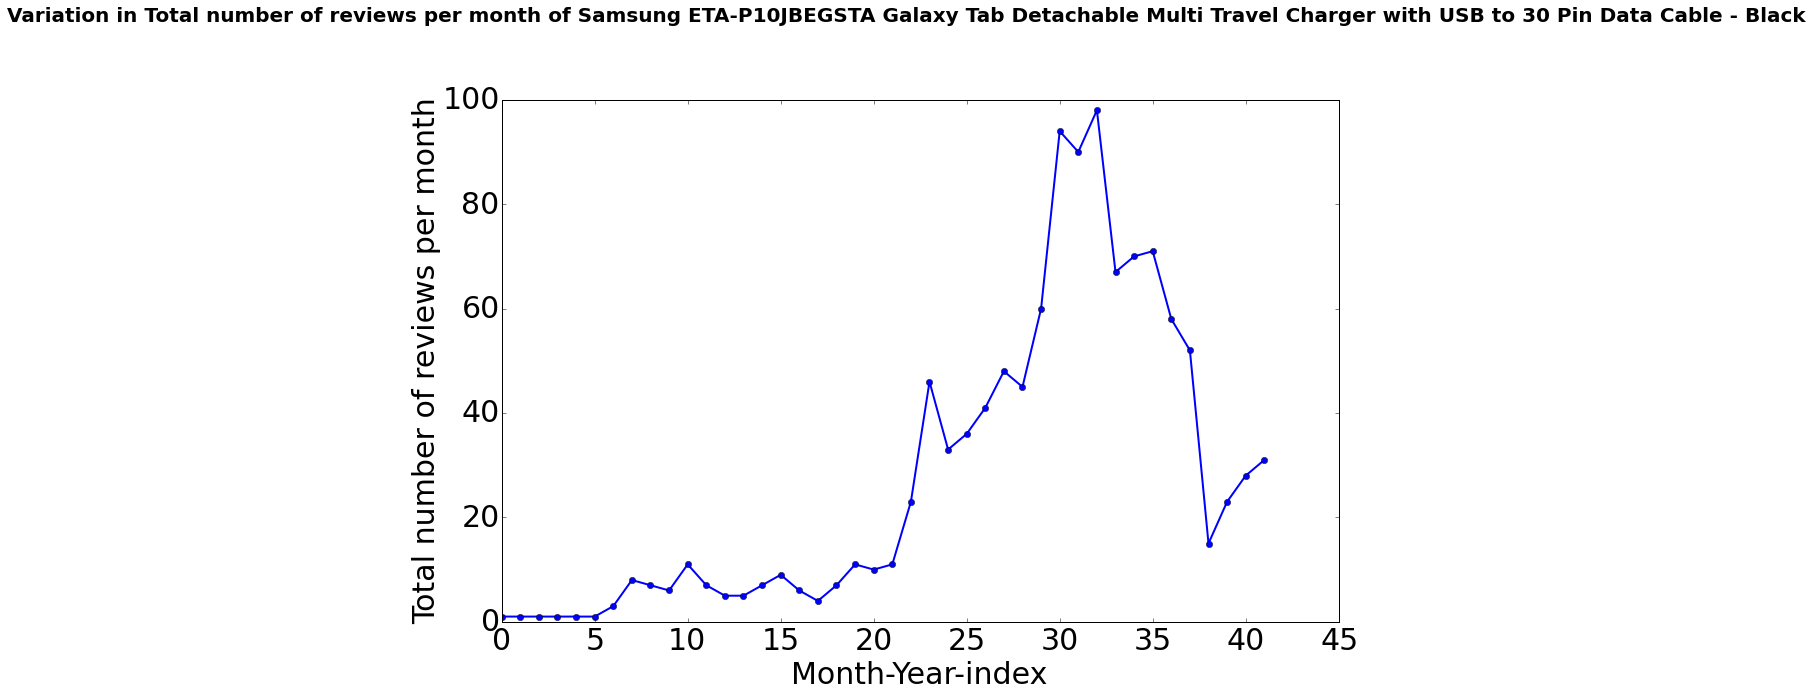

+------------+-------------+------------+-------+----------------+-----+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall | ... |
+------------+-------------+------------+-------+----------------+-----+
| B004CGHDEO |      12     |    2010    |   1   |      5.0       | ... |
| B004CGHDEO |      1      |    2011    |   1   |      4.0       | ... |
| B004CGHDEO |      2      |    2011    |   1   |      3.0       | ... |
| B004CGHDEO |      3      |    2011    |   1   |      5.0       | ... |
| B004CGHDEO |      6      |    2011    |   1   |      1.0       | ... |
| B004CGHDEO |      7      |    2011    |   1   |      5.0       | ... |
| B004CGHDEO |      8      |    2011    |   3   | 4.66666666667  | ... |
| B004CGHDEO |      9      |    2011    |   8   |     4.875      | ... |
| B004CGHDEO |      10     |    2011    |   7   | 4.57142857143  | ... |
| B004CGHDEO |      11     |    2011    |   6   | 4.83333333333  | ... |
| B004CGHDEO |      12     |    2011    |   11  | 4

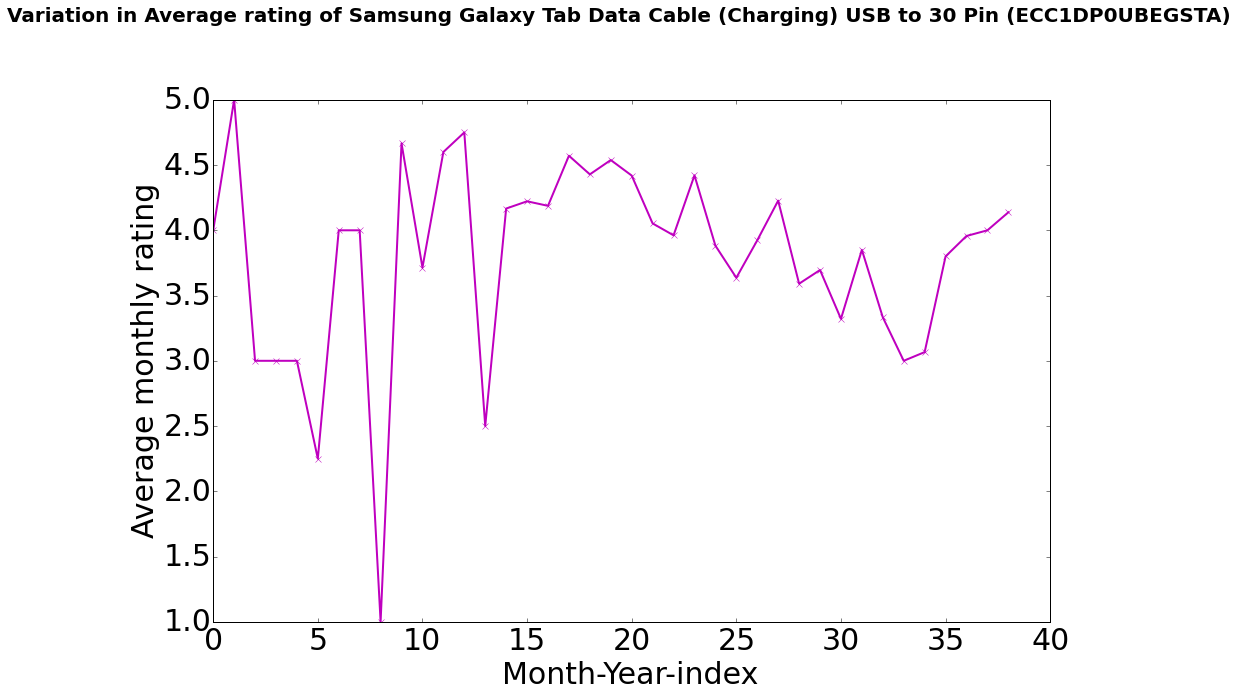

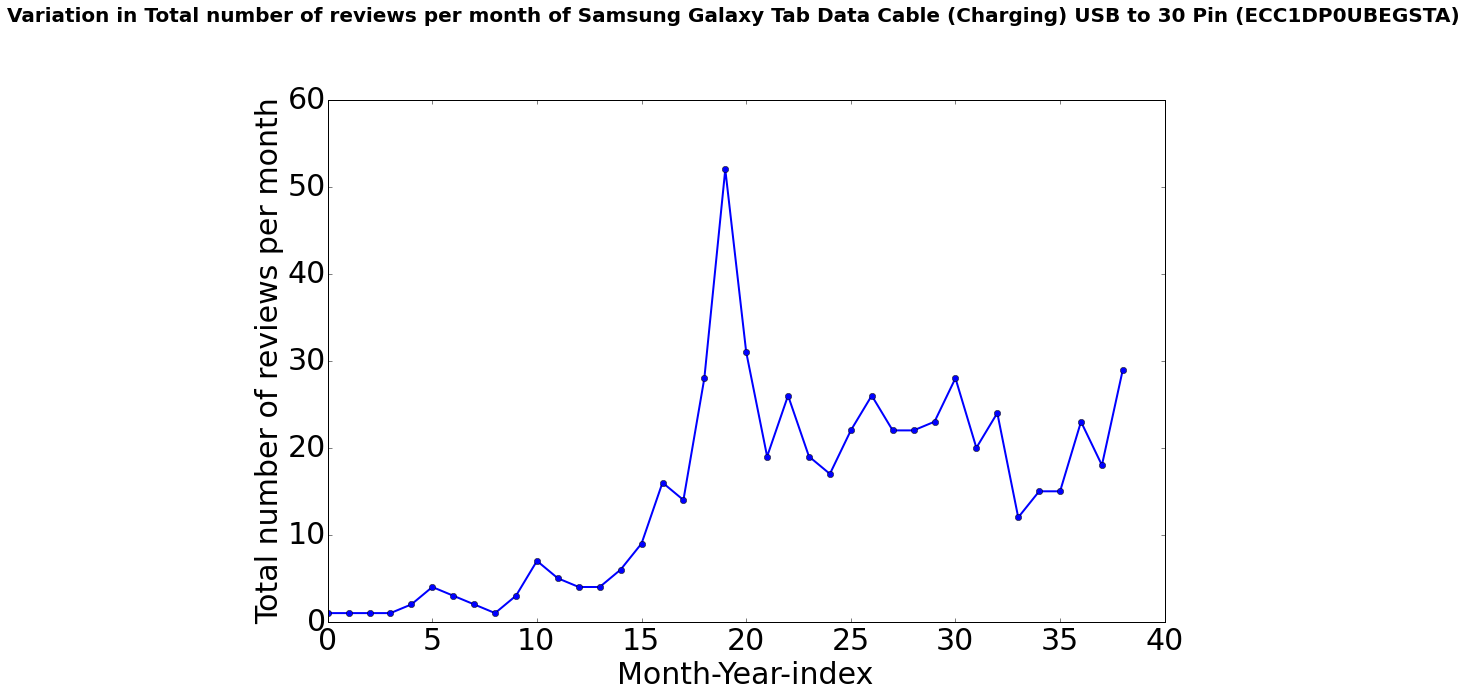

+------------+-------------+------------+-------+----------------+-----+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall | ... |
+------------+-------------+------------+-------+----------------+-----+
| B004DBD4TG |      12     |    2010    |   1   |      4.0       | ... |
| B004DBD4TG |      1      |    2011    |   1   |      5.0       | ... |
| B004DBD4TG |      3      |    2011    |   1   |      3.0       | ... |
| B004DBD4TG |      5      |    2011    |   1   |      3.0       | ... |
| B004DBD4TG |      6      |    2011    |   2   |      3.0       | ... |
| B004DBD4TG |      7      |    2011    |   4   |      2.25      | ... |
| B004DBD4TG |      8      |    2011    |   3   |      4.0       | ... |
| B004DBD4TG |      10     |    2011    |   2   |      4.0       | ... |
| B004DBD4TG |      11     |    2011    |   1   |      1.0       | ... |
| B004DBD4TG |      1      |    2012    |   3   | 4.66666666667  | ... |
| B004DBD4TG |      3      |    2012    |   7   | 3

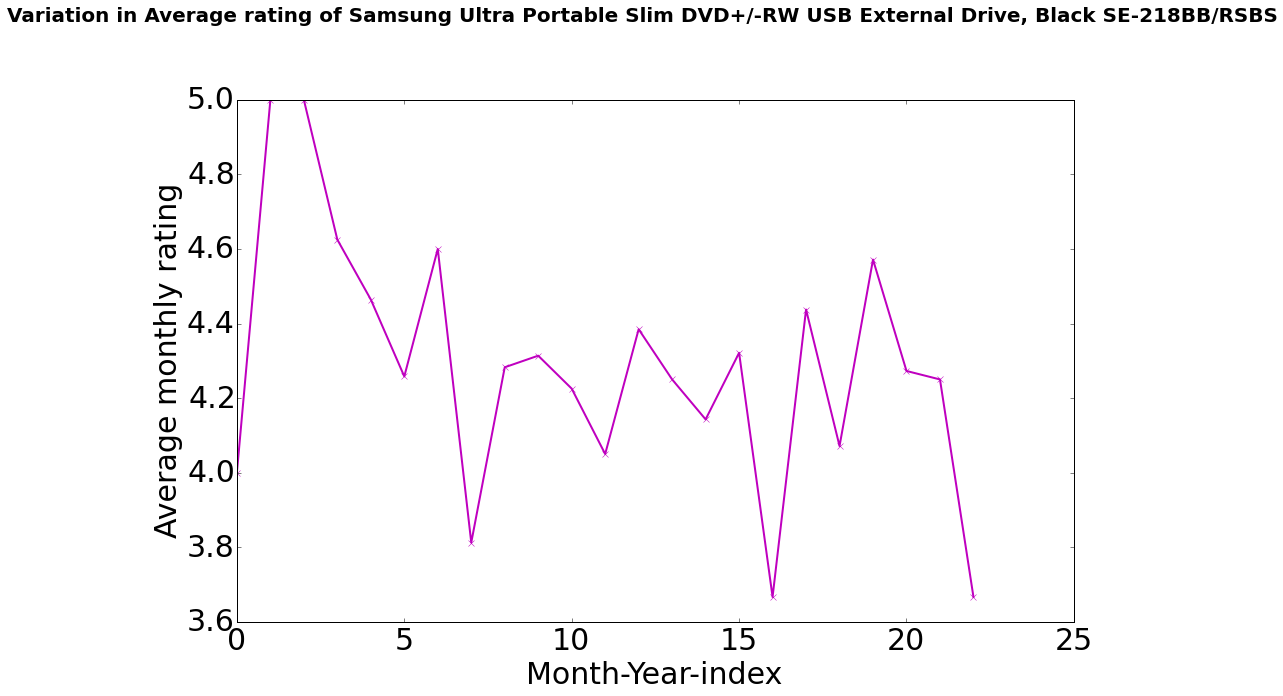

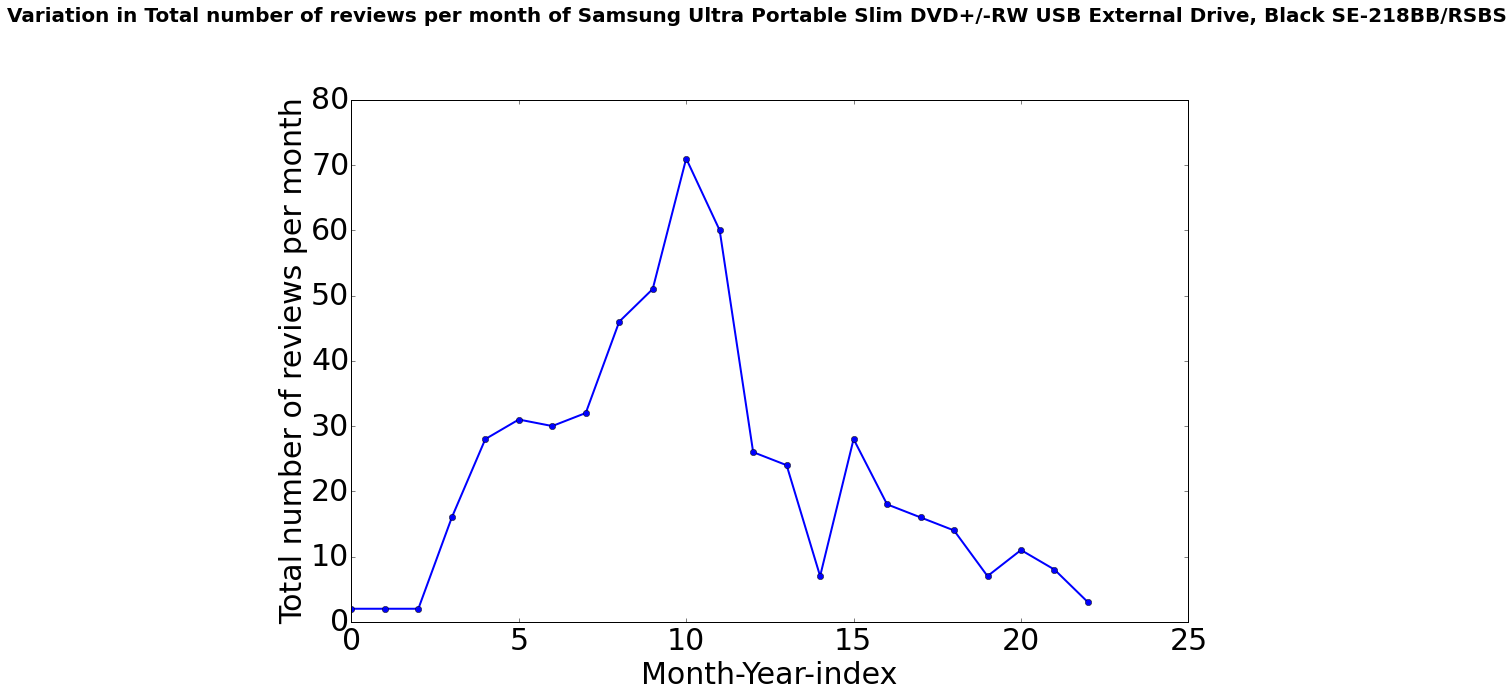

+------------+-------------+------------+-------+----------------+-----+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall | ... |
+------------+-------------+------------+-------+----------------+-----+
| B008AJLPYS |      9      |    2012    |   2   |      4.0       | ... |
| B008AJLPYS |      10     |    2012    |   2   |      5.0       | ... |
| B008AJLPYS |      11     |    2012    |   2   |      5.0       | ... |
| B008AJLPYS |      12     |    2012    |   16  |     4.625      | ... |
| B008AJLPYS |      1      |    2013    |   28  | 4.46428571429  | ... |
| B008AJLPYS |      2      |    2013    |   31  | 4.25806451613  | ... |
| B008AJLPYS |      3      |    2013    |   30  |      4.6       | ... |
| B008AJLPYS |      4      |    2013    |   32  |     3.8125     | ... |
| B008AJLPYS |      5      |    2013    |   46  | 4.28260869565  | ... |
| B008AJLPYS |      6      |    2013    |   51  |  4.3137254902  | ... |
| B008AJLPYS |      7      |    2013    |   71  | 4

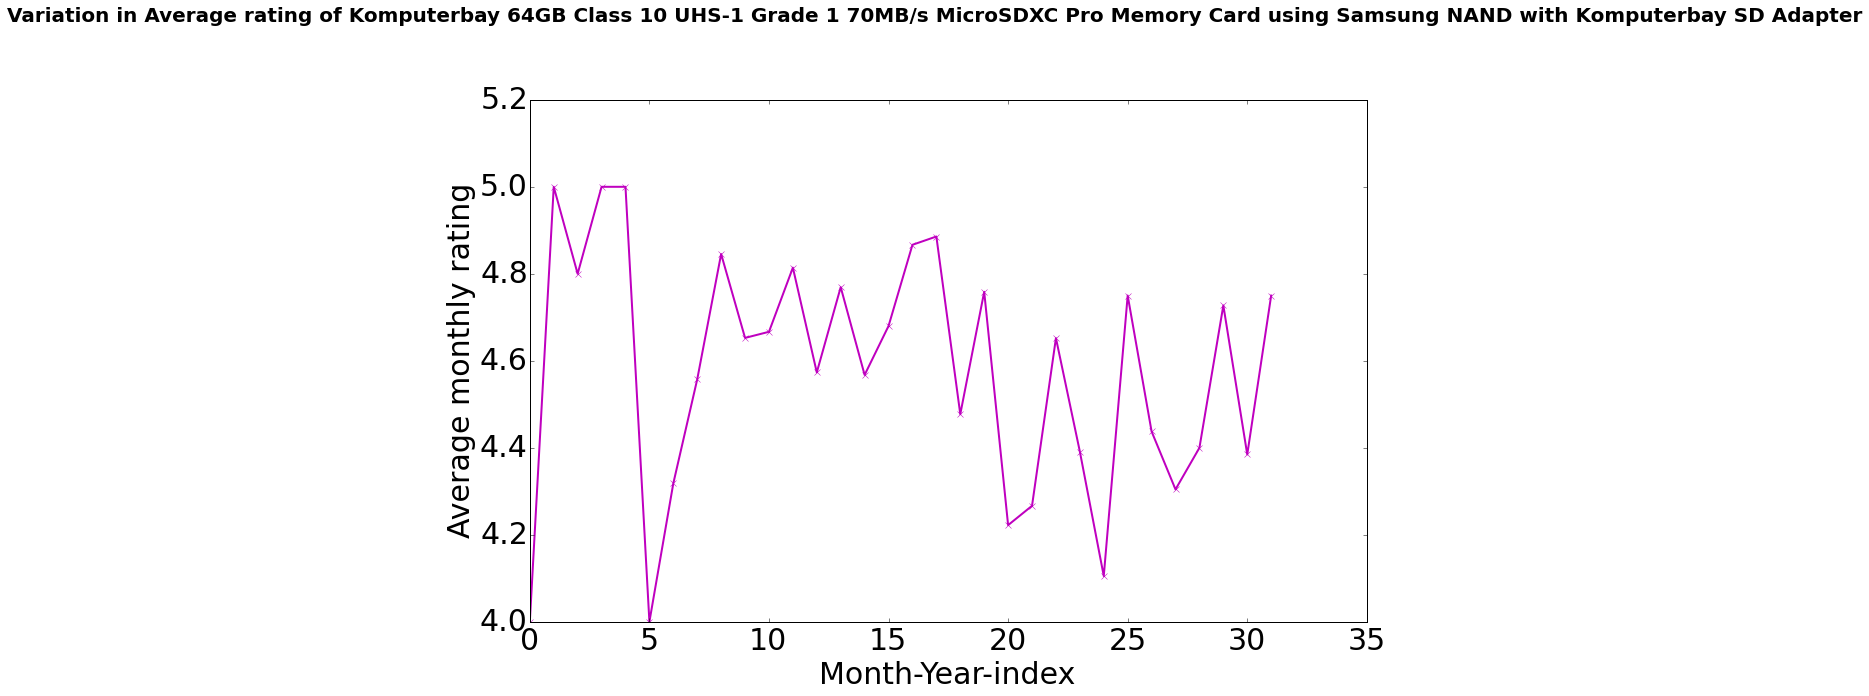

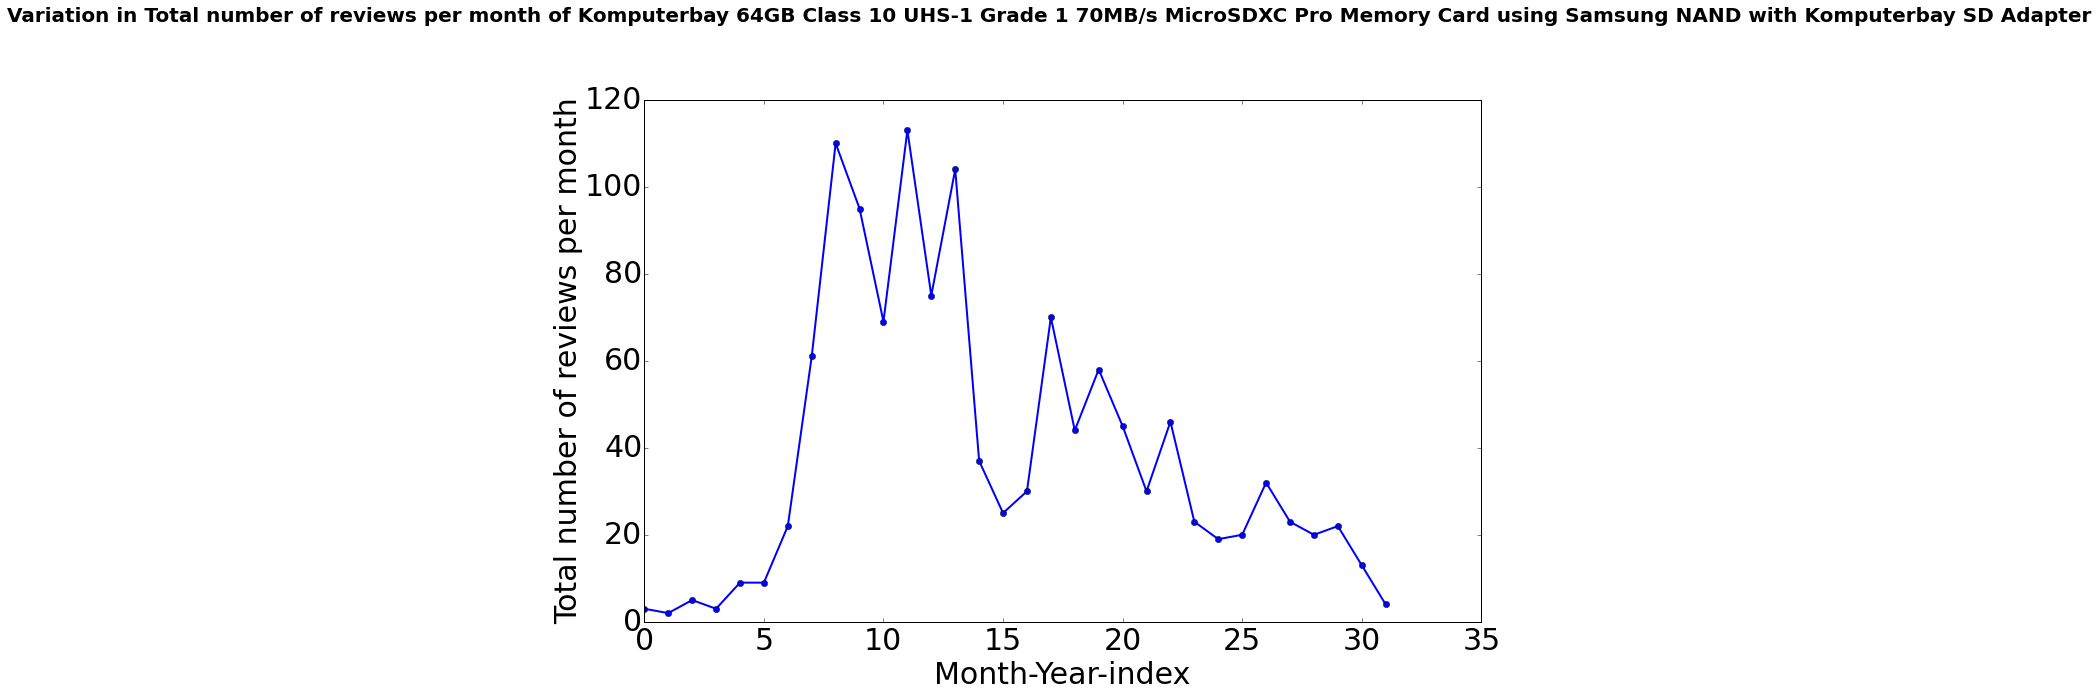

+------------+-------------+------------+-------+----------------+-----+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall | ... |
+------------+-------------+------------+-------+----------------+-----+
| B005VFG06W |      11     |    2011    |   3   |      4.0       | ... |
| B005VFG06W |      1      |    2012    |   2   |      5.0       | ... |
| B005VFG06W |      2      |    2012    |   5   |      4.8       | ... |
| B005VFG06W |      3      |    2012    |   3   |      5.0       | ... |
| B005VFG06W |      4      |    2012    |   9   |      5.0       | ... |
| B005VFG06W |      5      |    2012    |   9   |      4.0       | ... |
| B005VFG06W |      6      |    2012    |   22  | 4.31818181818  | ... |
| B005VFG06W |      7      |    2012    |   61  | 4.55737704918  | ... |
| B005VFG06W |      8      |    2012    |  110  | 4.84545454545  | ... |
| B005VFG06W |      9      |    2012    |   95  | 4.65263157895  | ... |
| B005VFG06W |      10     |    2012    |   69  | 4

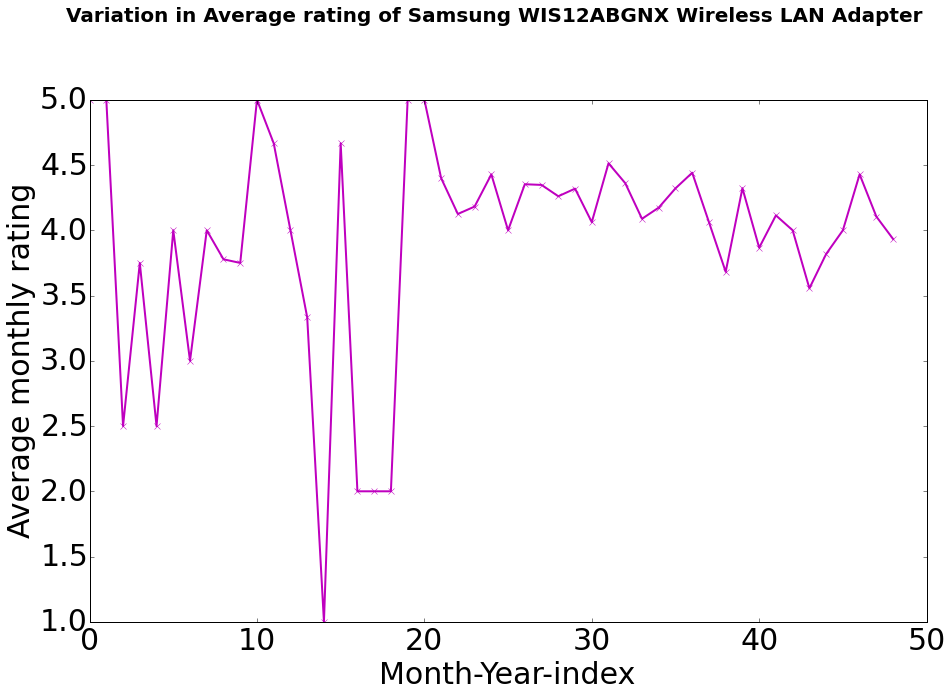

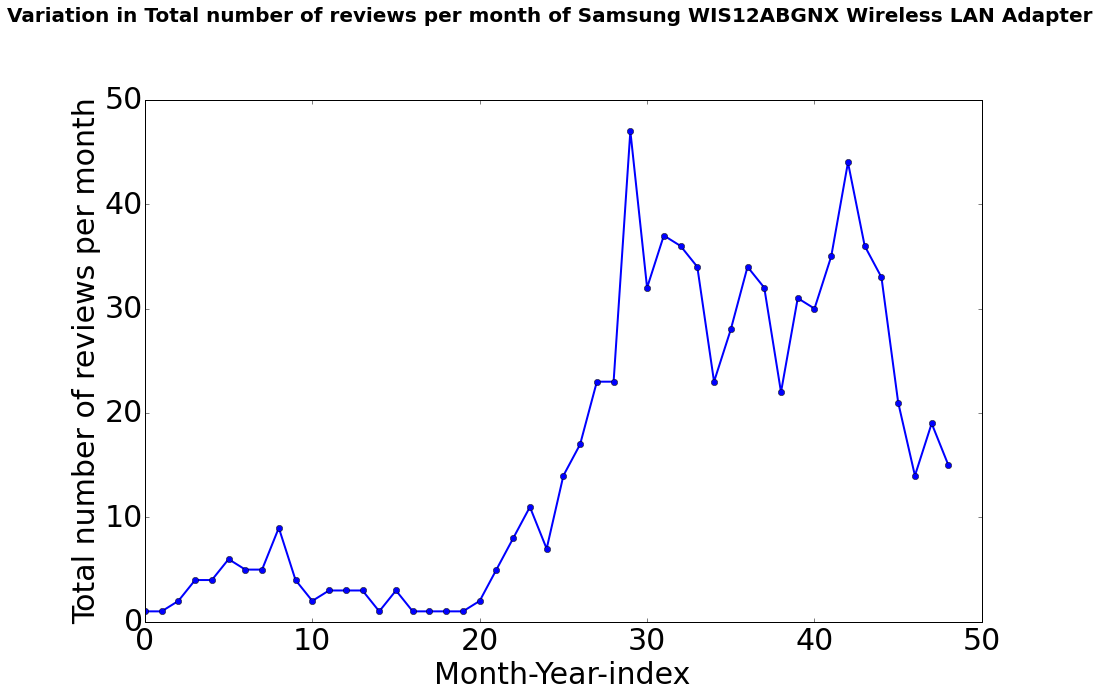

+------------+-------------+------------+-------+----------------+-----+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall | ... |
+------------+-------------+------------+-------+----------------+-----+
| B0079KZZKO |      4      |    2010    |   1   |      5.0       | ... |
| B0079KZZKO |      5      |    2010    |   1   |      5.0       | ... |
| B0079KZZKO |      6      |    2010    |   2   |      2.5       | ... |
| B0079KZZKO |      7      |    2010    |   4   |      3.75      | ... |
| B0079KZZKO |      8      |    2010    |   4   |      2.5       | ... |
| B0079KZZKO |      9      |    2010    |   6   |      4.0       | ... |
| B0079KZZKO |      10     |    2010    |   5   |      3.0       | ... |
| B0079KZZKO |      11     |    2010    |   5   |      4.0       | ... |
| B0079KZZKO |      12     |    2010    |   9   | 3.77777777778  | ... |
| B0079KZZKO |      1      |    2011    |   4   |      3.75      | ... |
| B0079KZZKO |      3      |    2011    |   2   |  

In [61]:
#plots for positive products
ctr=-1
for i in items_of_int_p:
    ctr=ctr+1
    producthist= product_elec_rating_stats_samsung_sorted_shortlist[product_elec_rating_stats_samsung_sorted_shortlist['asin'] 
                                                        == samsung_product_short_list[i]]
        
    timeline=range(len(producthist['Avg of overall']))
    
    fig = plt.figure(figsize=(15,10))

    figtitle='Variation in Average rating of'+' '+p_item_title_list[ctr]
  
    fig.suptitle(figtitle, fontsize=20, fontweight='bold')

    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=0.85)
#     ax.set_title('axes title',fontsize=30)

    ax.set_xlabel('Month-Year-index',fontsize=30)
    ax.set_ylabel('Average monthly rating',fontsize=30)
    for tick in ax.xaxis.get_major_ticks(): 
        tick.label.set_fontsize(30) 
    for tick in ax.yaxis.get_major_ticks(): 
        tick.label.set_fontsize(30)   


    ax.plot(timeline,list(producthist['Avg of overall']),'-mx',linewidth=2)

#     ax.axis([0, 50, 0, 5.5])
    plt.show()
    
    figtitle='Variation in Total number of reviews per month of'+' '+p_item_title_list[ctr]
   
    fig = plt.figure(figsize=(15,10))
    fig.suptitle(figtitle, fontsize=20, fontweight='bold')

    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=0.85)
#     ax.set_title('axes title',fontsize=30)

    ax.set_xlabel('Month-Year-index',fontsize=30)
    ax.set_ylabel('Total number of reviews per month',fontsize=30)
    for tick in ax.xaxis.get_major_ticks(): 
        tick.label.set_fontsize(30) 
    for tick in ax.yaxis.get_major_ticks(): 
        tick.label.set_fontsize(30)   


    ax.plot(timeline,list(producthist['Count']),'-bo',linewidth=2)
    
    plt.show()
    
    producthist.print_rows(num_rows=5000, num_columns=5)
    
    del producthist

In [70]:
##initialisation of product details
product_of_interest_id ='B0079KZZKO'
month_start,year_start=4,2010
month_end,year_end=7,2012
total_month_start=month_start+12*year_start
total_month_end=month_end+12*year_end
itemframe=product_elec_rating_stats_samsung_sorted_shortlist[product_elec_rating_stats_samsung_sorted_shortlist['asin']
                                                                 == product_of_interest_id]
#product name

temp_title= elec_meta_data[elec_meta_data['asin']==product_of_interest_id ]['title']
##avoiding syntax issues
item_title= str(temp_title[0])

itemframe['cumulativemonths']=itemframe['reviewmonth']+12*itemframe['reviewyear']

itemframe=itemframe[(itemframe['cumulativemonths']>=total_month_start) & (itemframe['cumulativemonths']<=total_month_end) ]

elec_rev_data_item= elec_rev_data[elec_rev_data['asin'] == product_of_interest_id]

itemframe['fulldate']=itemframe['reviewmonth'].astype(str)+'-'+itemframe['reviewyear'].astype(str)

check=itemframe['fulldate']

xnew=list(check.str_to_datetime("%m-%Y"))

xvvnew=[item.date() for item in xnew]

y=list(itemframe['Avg of overall'])

y2=list(itemframe['Count'])
    ##extracting the reviews

check=elec_rev_data_item['reviewTime']
xnew=check.str_to_datetime("%m %-d, %Y")
elec_rev_data_item['reviewday']=xnew.split_datetime('',limit=['day'])['day']
elec_rev_data_item['reviewmonth']=xnew.split_datetime('',limit=['month'])['month']
elec_rev_data_item['reviewyear']=xnew.split_datetime('',limit=['year'])['year']
elec_rev_data_item['cumulativemonths']=elec_rev_data_item['reviewmonth']+12*elec_rev_data_item['reviewyear']
elec_rev_data_item_small=elec_rev_data_item[(elec_rev_data_item['cumulativemonths']>=total_month_start) & 
                                            (elec_rev_data_item['cumulativemonths']<=total_month_end) ]

item_rev_list=list(elec_rev_data_item_small['reviewText'])

In [71]:
len(item_rev_list)

93

In [72]:
import re, string
from sklearn.feature_extraction.text import CountVectorizer 
from gensim.parsing.preprocessing import STOPWORDS

stopwords = list(STOPWORDS)

stopwords += ['.', ',', '(', ')', "'", '"']

univectorizer = CountVectorizer(ngram_range=(1,1))
unianalyzer = univectorizer.build_analyzer()
bivectorizer = CountVectorizer(ngram_range=(2,2))
bianalyzer = bivectorizer.build_analyzer()
trivectorizer = CountVectorizer(ngram_range=(3,3))
trianalyzer = trivectorizer.build_analyzer()

texts_uni = [re.sub('[%s]' % re.escape(string.punctuation), '', document.lower())
                  for document in item_rev_list]

texts_uni= [[word for word in document.lower().split() if word not in stopwords] for document in texts_uni]

texts_uni_join= [ " ".join(doc)for doc in texts_uni]



In [18]:
# texts_uni_join[0]

In [19]:
# texts_uni[0]

In [73]:
texts_bi= [bianalyzer(document) for document in texts_uni_join]

texts_tri= [trianalyzer(document) for document in texts_uni_join] 


    


In [74]:
# len(texts_tri)

93

[INFO] adding document #0 to Dictionary(0 unique tokens: [])
[INFO] built Dictionary(577 unique tokens: [u'works ok', u'limited', u'code', u'hint', u'lack']...) from 93 documents (total 2656 corpus positions)
[INFO] discarding 0 tokens: []...
[INFO] keeping 515 tokens which were in no less than 2 and no more than 65 (=70.0%) documents
[INFO] resulting dictionary: Dictionary(515 unique tokens: [u'works ok', u'limited', u'code', u'dollar', u'follow']...)
[INFO] saving Dictionary object under ./tmp/Samsung WIS12ABGNX Wireless LAN Adapter_B0079KZZKO.dct, separately None
[INFO] storing corpus in Matrix Market format to ./tmp/Samsung WIS12ABGNX Wireless LAN Adapter_B0079KZZKO.mm
[INFO] saving sparse matrix to ./tmp/Samsung WIS12ABGNX Wireless LAN Adapter_B0079KZZKO.mm
[INFO] PROGRESS: saving document #0
[INFO] saved 93x515 matrix, density=4.472% (2142/47895)
[INFO] saving MmCorpus index to ./tmp/Samsung WIS12ABGNX Wireless LAN Adapter_B0079KZZKO.mm.index
[INFO] using symmetric alpha at 0.2
[

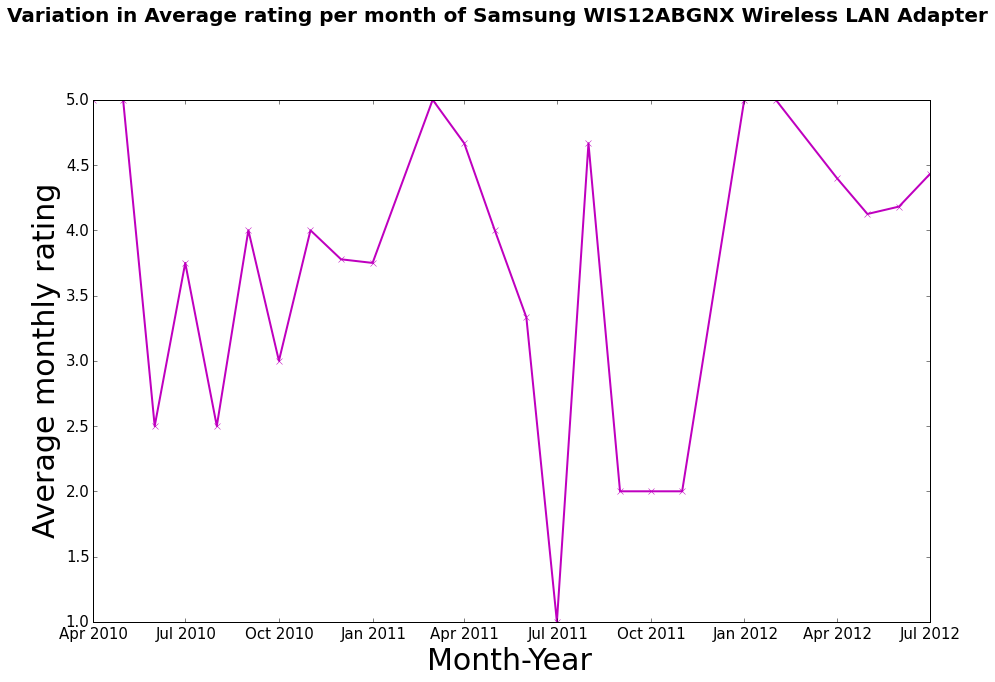

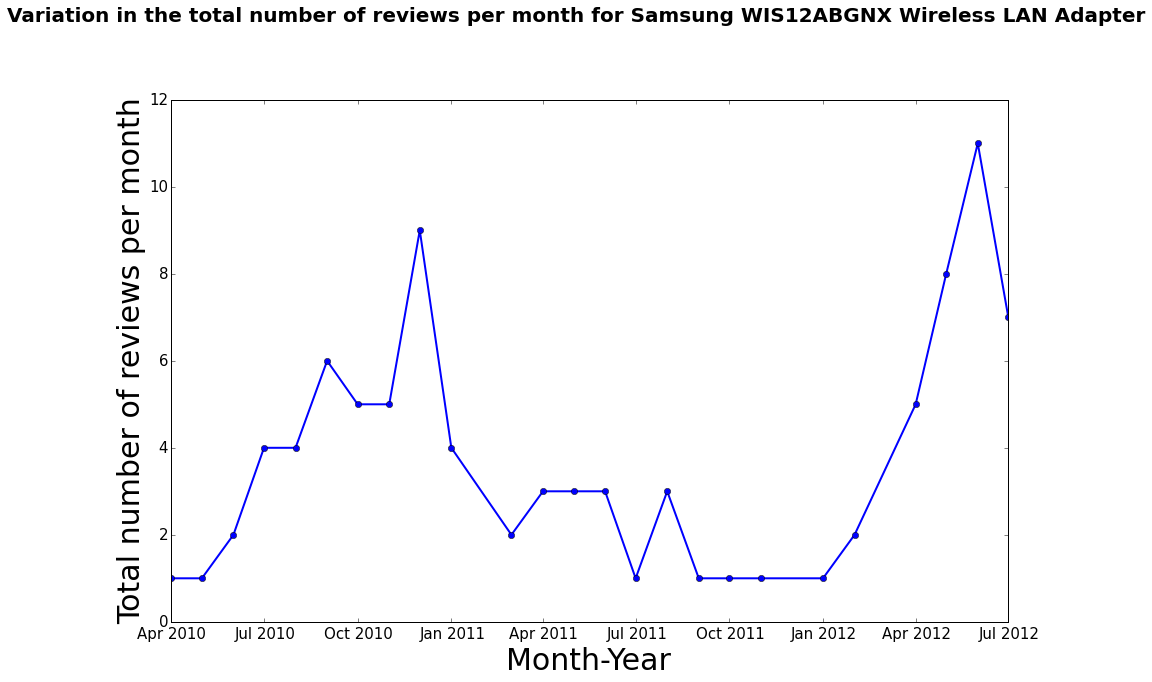

In [80]:
texts=[]
for i,j in enumerate(texts_tri):
    texts.append(texts_uni[i]+texts_bi[i]+ texts_tri[i])

# remove words that appear only once
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1]
              for text in texts]

dictionary = corpora.Dictionary(texts)
    # remove stop words and words that appear only once
stop_ids = [dictionary.token2id[stopword] for stopword in stopwords
                if stopword in dictionary.token2id]
once_ids = [tokenid for tokenid, docfreq in dictionary.dfs.iteritems() if docfreq == 1]

dictionary.filter_tokens(stop_ids + once_ids) # remove stop words and words that appear only once

dictionary.filter_extremes(no_below=2, no_above=0.7)# #remove extremes (similar to the min/max df step used when creating the tf-idf matrix)

dictionary.compactify() # remove gaps in id sequence after words that were removed
dctsavename= './tmp/'+ item_title +'_'+product_of_interest_id +'.dct'
dictionary.save(dctsavename)

    #creation of corpus
corpus = [dictionary.doc2bow(text) for text in texts]
corpsavename= './tmp/'+ item_title +'_'+product_of_interest_id +'.mm'
corpora.MmCorpus.serialize(corpsavename, corpus)

    #creation of model

model = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=5,update_every=1,chunksize=100000, passes=10,iterations=100)

# model = hdpmodel.HdpModel(bow_corpus, id2word=dictionary)
    #saving lda model
modsavename= './tmp/'+ item_title +'_'+product_of_interest_id +'.lda'
model.save(modsavename)
model.show_topics()
    
fig = plt.figure(figsize=(15,10))

figtitle='Variation in Average rating per month of'+' '+item_title
  
fig.suptitle(figtitle, fontsize=20, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
#     ax.set_title('axes title',fontsize=30)

ax.set_xlabel('Month-Year',fontsize=30)
ax.set_ylabel('Average monthly rating',fontsize=30)
for tick in ax.xaxis.get_major_ticks(): 
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks(): 
    tick.label.set_fontsize(15)   


ax.plot(xvvnew,y,'-mx',linewidth=2)

#     ax.axis([0, 50, 0, 5.5])
plt.show()
    
fig = plt.figure(figsize=(15,10))
figtitle='Variation in the total number of reviews per month for'+' '+item_title
  
fig.suptitle(figtitle, fontsize=20, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
#     ax.set_title('axes title',fontsize=30)

ax.set_xlabel('Month-Year',fontsize=30)
ax.set_ylabel('Total number of reviews per month',fontsize=30)
for tick in ax.xaxis.get_major_ticks(): 
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks(): 
    tick.label.set_fontsize(15)   

ax.plot(xvvnew,y2,'-bo',linewidth=2)

#     ax.axis([0, 50, 0, 5.5])
plt.show()


In [81]:
pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(model, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      37.062019        1       1 -0.004872 -0.112119
2      22.973146        1       2 -0.017870  0.100224
1      16.276011        1       3 -0.135802  0.004072
4      15.424554        1       4  0.064127 -0.034962
3       8.264270        1       5  0.094416  0.042786, topic_info=    Category       Freq             Term  Total  loglift  logprob
152  Default  28.000000          product     28  30.0000  30.0000
463  Default  59.000000         wireless     59  29.0000  29.0000
487  Default  11.000000          plugged     11  28.0000  28.0000
383  Default  17.000000             easy     17  27.0000  27.0000
227  Default  13.000000              ray     13  26.0000  26.0000
9    Default  62.000000               tv     62  25.0000  25.0000
408  Default  33.000000            works     33  24.0000  24.0000
339  Default  38.000000           player     38  23.0000  23.0000
208  Default   8.000000          adaptor      8  22.0000  22.0000
183  Default  36.000000           router     36  21.0000  21.0000
268  Default  19.000000           bluray     19  20.0000  20.0000
140  Default  10.000000       ray player     10  19.0000  19.0000
287  Default  21.000000           bought     21  18.0000  18.0000
252  Default  13.000000             fine     13  17.0000  17.0000
164  Default  15.000000         internet     15  16.0000  16.0000
32   Default   9.000000             blue      9  15.0000  15.0000
424  Default   9.000000         blue ray      9  14.0000  14.0000
400  Default   6.000000           signal      6  13.0000  13.0000
471  Default  64.000000          samsung     64  12.0000  12.0000
231  Default   9.000000      works great      9  11.0000  11.0000
229  Default   6.000000         firmware      6  10.0000  10.0000
454  Default   9.000000              way      9   9.0000   9.0000
492  Default  11.000000         problems     11   8.0000   8.0000
44   Default  19.000000            great     19   7.0000   7.0000
299  Default   4.000000     installation      4   6.0000   6.0000
310  Default   4.000000    product works      4   5.0000   5.0000
340  Default   9.000000               im      9   4.0000   4.0000
25   Default  15.000000             item     15   3.0000   3.0000
85   Default  11.000000           movies     11   2.0000   2.0000
82   Default   8.000000            setup      8   1.0000   1.0000
..       ...        ...              ...    ...      ...      ...
229   Topic5   2.415658         firmware      6   1.4868  -4.5502
31    Topic5   1.564495         download      4   1.5173  -4.9253
383   Topic5   5.076142             easy     17   1.1088  -3.8868
152   Topic5   7.306253          product     28   0.9660  -3.5306
33    Topic5   1.623761     easy install      5   1.2973  -4.9221
198   Topic5   1.623834                2      5   1.2952  -4.9242
197   Topic5   1.578736           needed      5   1.2942  -4.9252
493   Topic5   1.558165           update      5   1.2940  -4.9254
486   Topic5   1.056637            floor      3   1.4615  -5.2688
140   Topic5   2.554793       ray player     10   0.9758  -4.5505
85    Topic5   2.487113           movies     11   0.8813  -4.5496
492   Topic5   2.466845         problems     11   0.8806  -4.5504
268   Topic5   3.340150           bluray     19   0.6061  -4.2783
59    Topic5   1.656242  blue ray player      6   1.1120  -4.9251
287   Topic5   3.329342           bought     21   0.5061  -4.2782
227   Topic5   2.600070              ray     13   0.7132  -4.5507
339   Topic5   4.201647           player     38   0.1260  -4.0653
408   Topic5   3.864463            works     33   0.1954  -4.1369
144   Topic5   1.647482     instructions      7   0.9588  -4.9241
44    Topic5   2.489520            great     19   0.3348  -4.5496
183   Topic5   3.222987           router     36  -0.0939  -4.3392
231   Topic5   1.618000      works great      9   0.7065  -4.9251
27    Topic5   

In [82]:
#clustering the documents according to their content
corpus_lda = model[corpus]
doc_dict={}
for docid,doc in enumerate(corpus_lda): 
    print doc
    doc_topics=[item[0] for item in doc]
    doc_topic_prob=[item[1] for item in doc]
    doc_dict[docid]=[doc_topics,doc_topic_prob]
    
        

    
    
            
            
            
            
            
            
            
            

[(4, 0.97287327770378174)]
[(0, 0.88493194490931881), (1, 0.028745209182017225), (2, 0.02883483362491706), (3, 0.028576292047458131), (4, 0.028911720236288851)]
[(1, 0.098379900184030672), (3, 0.27047717189949877), (4, 0.61485812685074914)]
[(0, 0.010274069630122942), (1, 0.010195577193649009), (2, 0.010239318304699567), (3, 0.010191464415712417), (4, 0.95909957045581606)]
[(0, 0.9663098388232173)]
[(4, 0.98342257654138576)]
[(2, 0.98111740025313166)]
[(0, 0.020436103150556877), (1, 0.37549619203855017), (2, 0.020187316146836738), (3, 0.56363478658412836), (4, 0.020245602079927934)]
[(0, 0.94224346815968407), (1, 0.014566750770041962), (2, 0.014412612810283833), (3, 0.014408514575071087), (4, 0.014368653684918924)]
[(0, 0.017026110144213766), (1, 0.016835359378323356), (2, 0.93239714595762646), (3, 0.016875333502913068), (4, 0.01686605101692339)]
[(0, 0.97466920665281531)]
[(3, 0.96624206871787977)]
[(0, 0.95711567286596266), (1, 0.010681675417999449), (2, 0.01065392610139477), (3, 0.0

In [83]:
###classifying each document as belonging to 
import operator

topic_0_docs_idx=[]
topic_1_docs_idx=[]
topic_2_docs_idx=[]
topic_3_docs_idx=[]
topic_4_docs_idx=[]

for k,v in doc_dict.items():
    topicslist=v[0]
    problist=v[1]
    max_index, max_value = max(enumerate(problist), key=operator.itemgetter(1))
    topic_index=topicslist[max_index]
    if topic_index==0:
        topic_0_docs_idx.append(k)
    elif topic_index==1:
        topic_1_docs_idx.append(k)
    elif topic_index==2:
        topic_2_docs_idx.append(k)        
    elif topic_index==3:
        topic_3_docs_idx.append(k)
    elif topic_index==4:
        topic_4_docs_idx.append(k)
    
    

In [154]:
# print len(topic_0_docs_idx),len(topic_1_docs_idx),len(topic_2_docs_idx),len(topic_3_docs_idx),len(topic_4_docs_idx)

dict_vec={}
dict_vec[0]=0
dict_vec[1]=0
dict_vec[2]=0
dict_vec[3]=0
dict_vec[4]=0
mag0,mag1,mag2,mag3,mag4=0,0,0,0,0
for item in topic_0_docs_idx:

        for idx,z in enumerate(doc_dict[item][0]):

                 dict_vec[z]+=doc_dict[item][1][idx]
print dict_vec
#         print components
#         print magnitudes


{0: 31.541165609908582, 1: 0.25935621898826389, 2: 0.77464063786912007, 3: 0.25895572523857829, 4: 0.75700100285859218}


In [157]:
vec_lda=[]
for k,v in dict_vec.items():
    vec_lda.append((k,v))
print vec_lda
#  query in LDA space
# vec_lda=
index = similarities.MatrixSimilarity(model[corpus]) # transform corpus to LDA space and index it
sims = index[vec_lda] # perform a similarity query against the corpus
# print(list(enumerate(sims))) # print (document_number, document_similarity) 2-tuples
sims = sorted(enumerate(sims), key=lambda item: -item[1])
print(sims) # print sorted (document number, similarity score) 2-tuples

[WARNING] scanning corpus to determine the number of features (consider setting `num_features` explicitly)
[INFO] creating matrix for 93 documents and 5 features


[(0, 31.541165609908582), (1, 0.25935621898826389), (2, 0.77464063786912007), (3, 0.25895572523857829), (4, 0.75700100285859218)]
[(17, 0.9998734), (8, 0.99986774), (77, 0.99986774), (68, 0.99986571), (72, 0.99986094), (63, 0.99985808), (58, 0.99984717), (67, 0.99984217), (90, 0.99983358), (53, 0.99982977), (12, 0.99982029), (86, 0.99981064), (45, 0.99972761), (1, 0.99934858), (22, 0.99934804), (4, 0.99934351), (10, 0.99934351), (15, 0.99934351), (26, 0.99934351), (38, 0.99934351), (42, 0.99934351), (50, 0.99934351), (55, 0.99934351), (62, 0.99934351), (66, 0.99934351), (70, 0.99934351), (73, 0.99934351), (76, 0.99934351), (79, 0.99934351), (80, 0.99934351), (85, 0.99934351), (40, 0.98236203), (33, 0.88072646), (48, 0.83006656), (89, 0.6654442), (19, 0.65117431), (61, 0.42293936), (25, 0.073907837), (49, 0.046933033), (14, 0.046816736), (46, 0.046781756), (41, 0.045191154), (9, 0.043490086), (7, 0.042922184), (27, 0.042521898), (92, 0.041633569), (44, 0.04127739), (78, 0.041257996), (5

In [158]:
item_rev_list[0]
# tfidf = models.TfidfModel(corpus)

# data=pyLDAvis.gensim.prepare(model, corpus, dictionary)
# pyLDAvis.save_html(data, 'pyldavis_koj.html')
# !python -m SimpleHTTPServer 8000
# def tokenize_and_stem(document):
    
#     texts_uni = [re.sub('[%s]' % re.escape(string.punctuation), '', document.lower())
#                   for document in item_rev_list]

#     texts_uni= [[word for word in document.lower().split() if word not in stopwords] for document in texts_uni]

#     texts_uni[0]

"The Samsung WIS09ABGN2 seemed more intimidating that it actually was -- with help from Samsung and my wireless provider.  Codes between the two are not standard making for some confusion, but the Qwest help person really was helpful.  Not so for the Samsung help provider who was extremely slow, didn't seem to understand the questions, and eventually simply quit the session!The Samsung WIS09ABGN2 works just fine.  The owner's manual isn't very helpful about the streaming aspect of the device, but Netflix and other Apps seem to work."

In [109]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# synopses=["This is very strange",
#           "any pig strange"]
# #define vectorizer parameters
# tfidf_vectorizer = TfidfVectorizer(use_idf=True)

# tfidf_matrix = tfidf_vectorizer.fit_transform(synopses) #fit the vectorizer to synopses

# print(tfidf_matrix)
# print dict(zip(vectorizer.get_feature_names(), idf))

In [107]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# corpus = ["This is very strange",
#           "This is very nice"]
# vectorizer = TfidfVectorizer(min_df=1)
# X = vectorizer.fit_transform(corpus)
# idf = vectorizer.idf_
# print dict(zip(vectorizer.get_feature_names(), idf))

In [108]:
# " ".join(texts[3])

In [27]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# x=[1,2,3,4,5]
# y=[1,3,5,7,9]

# plt.figure(figsize=(25,15))
# plt.xlabel('Month-Year',fontsize=14)
# plt.ylabel('Total # of Reviews/Month')
# plt.plot(x, y,'-bo', linewidth=2)#-rd

In [43]:
# model = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20)

In [44]:
# pyLDAvis.gensim.prepare(model, corpus, dictionary)
